<a href="https://colab.research.google.com/github/YushkevichNV/semantic_segmentation/blob/main/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>Сегментация изображений</b></h3>


Перед нами стоит задача сегментации медицинских снимков. 




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>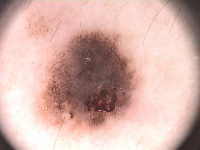</td><td>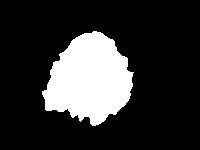</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
Мы будем **сегментировать** их.

In [ ]:
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2022-07-26 09:12:28--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2022-07-26 09:12:29--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc48b69505a20fada79a24be4500.dl.dropboxusercontent.com/cd/0/inline/BpwgzdlkJhcJDJbsYAjAA-sfMgITeYZbLL1d-3hvff6jeYdUPbdCBVmScvyI1qmhCxeXFJLq38pPtvHoy9CnK7eGlztnptr-b_F2NeSHjeJXrSG_b9qaSu6oO_81jp9IaK1PMZcECO0Gzw-uuuy738-Hk9h3ZTXOzuFrAwQn3s6I5w/file# [following]
--2022-07-26 09:12:29--  https://uc48b69505a20fada79a24be4500.dl.dropboxusercontent.com/cd/0/inline/BpwgzdlkJhcJDJbsYAjAA-sfMgITeYZbLL1d-3hvff6jeYdUPbdCBVmScvyI

In [ ]:
!pip install googledrivedownloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

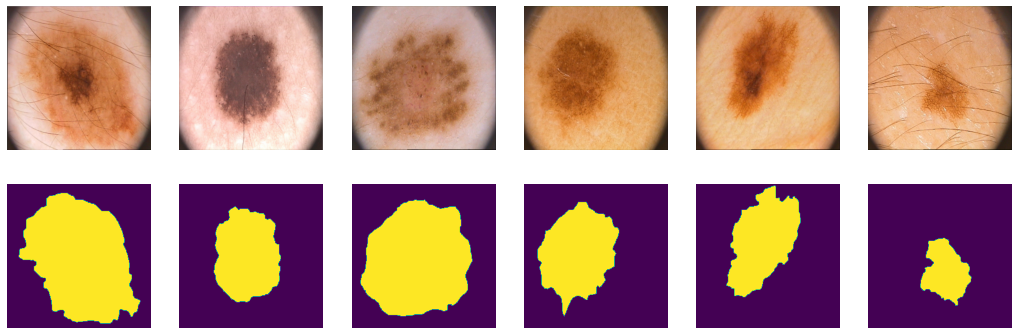

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


In [ ]:
X[tr].shape

(100, 256, 256, 3)

#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:


-----------------------------------------------------------------------------------------

# SegNet

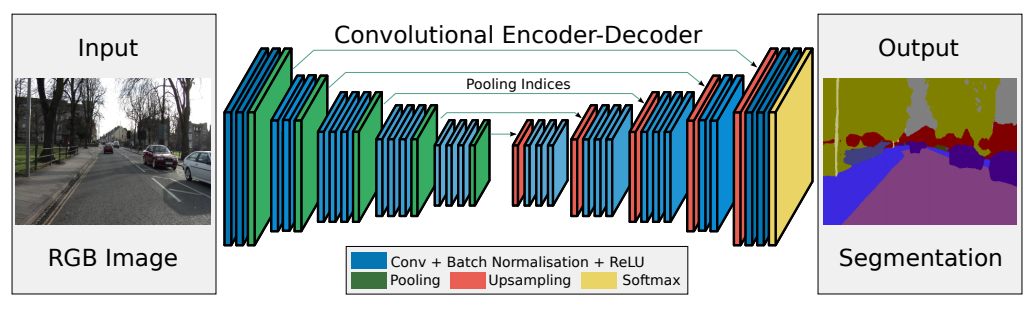

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv4 = nn.Sequential(
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)


        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
                  nn.Conv2d(512, 512, 3, 1, 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, 3, 1, 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, 3, 1, 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.upsample1 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 512, 3, 1, 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, 3, 1, 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, 3, 1, 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 256, 3, 1, 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, 3, 1, 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, 3, 1, 1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 128, 3, 1, 1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, 3, 1, 1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample4 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv4 = nn.Sequential(
                  nn.Conv2d(64, 64, 3, 1, 1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, 3, 1, 1))

    def forward(self, x):

        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        e4, ind4 = self.pool4(self.enc_conv4(e3))


        # decoder
        d0 = self.dec_conv0(self.upsample0(e4,ind4))
        d1 = self.dec_conv1(self.upsample1(d0,ind3))
        d2 = self.dec_conv2(self.upsample2(d1,ind2))
        d3 = self.dec_conv3(self.upsample3(d2,ind1))
        d4 = self.dec_conv4(self.upsample4(d3,ind0))
        return d4

## Метрика

Будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    return (y_pred - (y_real * y_pred) + torch.log(1 + torch.exp(-y_pred))).sum()

## Тренировка 
Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu() 

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        

## Инференс 

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

        del Y_pred, Y_label, X_batch
        torch.cuda.memory.empty_cache()
    return scores/len(data)

## Обучение

Обучим науш модель.


In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 5
optimize = torch.optim.Adam(model.parameters())
losses = train(model, optimize, bce_loss, max_epochs, data_tr, data_val)

* Epoch 1/5
tensor([[[0.1602, 0.1721, 0.1735,  ..., 0.1456, 0.1539, 0.1127],
         [0.1837, 0.1956, 0.2000,  ..., 0.1609, 0.1715, 0.1298],
         [0.1960, 0.2073, 0.1996,  ..., 0.1726, 0.1779, 0.1401],
         ...,
         [0.1783, 0.1848, 0.1794,  ..., 0.1383, 0.1431, 0.1131],
         [0.1803, 0.1877, 0.1872,  ..., 0.1553, 0.1515, 0.1087],
         [0.1318, 0.1343, 0.1382,  ..., 0.0892, 0.0902, 0.0696]],

        [[0.1333, 0.1387, 0.1490,  ..., 0.1206, 0.1269, 0.0936],
         [0.1416, 0.1495, 0.1568,  ..., 0.1368, 0.1294, 0.1029],
         [0.1450, 0.1529, 0.1451,  ..., 0.1255, 0.1260, 0.1048],
         ...,
         [0.1220, 0.1245, 0.1245,  ..., 0.1226, 0.1206, 0.0975],
         [0.1215, 0.1294, 0.1328,  ..., 0.1123, 0.1152, 0.0887],
         [0.0838, 0.0917, 0.0941,  ..., 0.0490, 0.0500, 0.0529]],

        [[0.1465, 0.1598, 0.1583,  ..., 0.1313, 0.1299, 0.1004],
         [0.1298, 0.1378, 0.1455,  ..., 0.1186, 0.1069, 0.0950],
         [0.1406, 0.1441, 0.1412,  ..., 0.0981

KeyboardInterrupt: ignored

In [1]:
score_model(model, iou_pytorch, data_val)

0.5700000077486038

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 


$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    return (-1) * ((((1-y_pred)**gamma) * y_real * torch.log(y_pred)) + ((1-y_real) * torch.log(1-y_pred))).sum()

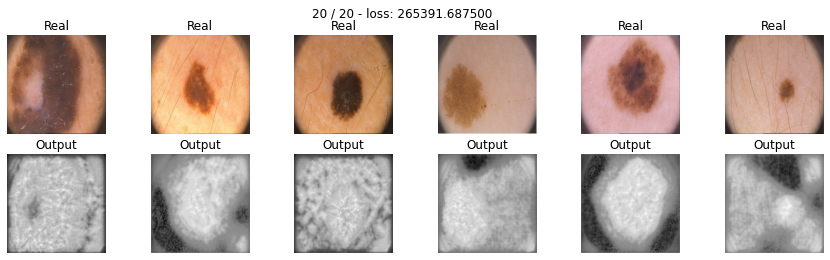

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [2]:
score_model(model_focal, iou_pytorch, data_val)

0.07000000029802322

-----------------------------------------------------------------------------------------

# U-Net 


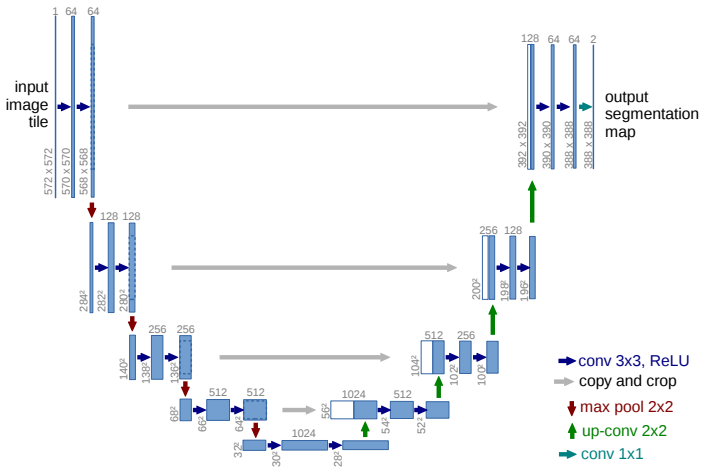

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                  nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                  nn.BatchNorm2d(1024),
                  nn.ReLU(),
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, kernel_size=1))

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.pool3(self.bottleneck_conv(e3))

        #decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], dim=1))
        return d3

In [ ]:
unet_model = UNet().to(device)

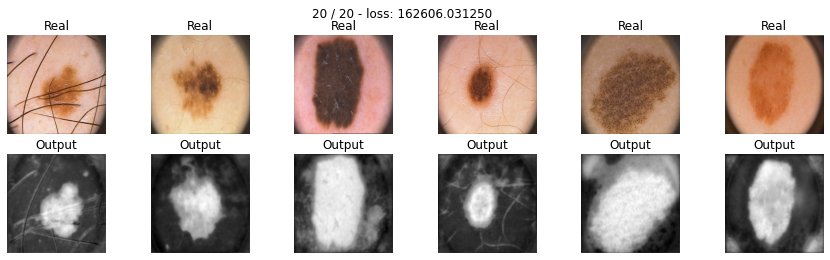

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.6483333706855774